In [2]:
import pandas as pd
import numpy as np
import requests
import matplotlib.pyplot as plt
import json
from bs4 import BeautifulSoup
import re
import urllib
import os

---

---

# IMDb Dataframes

## df_akas

In [ ]:
df_akas = pd.read_csv('title.akas.tsv', sep='\t')

In [ ]:
df_akas.shape

In [ ]:
df_akas.iloc[11000000:11000020]

In [ ]:
df_akas.loc[(df_akas['titleId']=='tt6105098')&(df_akas['region']=='US')]
# df_akas.loc[(df_akas['titleId']=='tt4154796')]

In [ ]:
df_akas.loc[(df_akas['title']=='The Sixth Sense')&(df_akas['region']=='US')]

In [ ]:
df_akas[df_akas['isOriginalTitle']==1]['language'].unique()

In [ ]:
df_akas.attributes.iloc[100:150]

In [ ]:
df_akas.language.value_counts().head(20)

In [ ]:
df_akas.region.value_counts().head(20)

In [ ]:
df_akas[df_akas['title'] == 'The Wind'].head(50)

## df_basics

In [ ]:
df_basics = pd.read_csv('title.basics.tsv', sep='\t')

In [ ]:
df_basics.iloc[1500000:1500010]

## df_ratings

In [ ]:
df_ratings = pd.read_csv('title.ratings.tsv', sep='\t')

In [ ]:
df_ratings

---

---

# Box Office Mojo Worldwide DF

In [5]:
url = 'https://www.boxofficemojo.com/year/world/'
def get_worldwide(url):
    '''
    take in a url and obtain a list of urls to parse through
    '''
    #container for holding dataframe
    container = []
    
    #for each year between 1999, 2019, create a url to easily read the html and output a dataframe of top 100 in year
    for year in range(1999,2020): #1999, 2019   
        df = pd.read_html(url + str(year))       
        container.append(df[0][:100]) 
    #concat the list of dataframes and return one big dataframe
    return pd.concat(container, axis = 0, ignore_index = True)
df = get_worldwide(url)
df

,Rank,Release Group,Worldwide,Domestic,%,Foreign,%.1
0,1,Star Wars: Episode I - The Phantom Menace,"$924,305,084","$431,088,295",46.6%,"$493,216,789",53.4%
1,2,The Sixth Sense,"$672,806,292","$293,506,292",43.6%,"$379,300,000",56.4%
2,3,Toy Story 2,"$487,059,677","$245,852,179",50.5%,"$241,207,498",49.5%
3,4,The Matrix,"$463,517,383","$171,479,930",37%,"$292,037,453",63%
4,5,Tarzan,"$448,191,819","$171,091,819",38.2%,"$277,100,000",61.8%
...,...,...,...,...,...,...,...
2095,96,Just Mercy,"$50,401,502","$36,001,502",71.4%,"$14,400,000",28.6%
2096,97,Uncut Gems,"$50,023,780","$50,023,780",100%,-,-
2097,98,21 Bridges,"$49,939,757","$28,539,757",57.1%,"$21,400,000",42.9%
2098,99,Little,"$48,987,096","$40,860,481",83.4%,"$8,126,615",16.6%


# Box Office Mojo - Foreign Markets

In [ ]:
def get_worldwide_link_list(url):
    '''
    Given the url to a year, obtain a list of working urls to later parse through
    '''
    container = []
    for year in range(2019,1998,-1): #1999, 2019
        url + str(year)
        container.append(url + str(year))
    return container

In [ ]:
def get_country_hyperlinks(link_list):    #give it a list
    '''
    Given a list of year urls, go into the hyperlink of each table row (title of movie),
    Retrieve a long list of hyperlinks containing country revenue information
    '''
    link_results = []
    for link in link_list:   #use one entry for ex. 2019
        page = requests.get(link) #requests 2019 url
        src = page.content  #turn to page
        soup = BeautifulSoup(src, 'html.parser') #turn 2019 to soup
        all_a = soup.find_all('a') #grab anchors from 2019 soup an put into a list of links
        c = []  
        for x in all_a: #looking through hyper links 'hrefs'
            c.append(x.attrs['href']) #append link to container
            # cleans hyperlinks to only include relevant
        movie_urls_year = []
        for x in c[:119]:         #filters through slice of container to get wanted releasegroup urls
            if 'releasegroup' in x:   
                movie_urls_year.append(x)
        link_results.extend(movie_urls_year)
    return link_results

# get_country_hyperlinks(link_list)

In [ ]:
def get_countries_for_title(url):
    '''
    For given url, go to site and obtain foriegn countries revenue if possible
    '''
    # Make a request for each title
    html_table = urllib.request.urlopen('https://www.boxofficemojo.com/{}'.format(url)).read()

    # Turn into soup
    soop = BeautifulSoup(html_table, "html.parser")
    
    # Grab title
    title = soop.find('h1', class_='a-size-extra-large').get_text()
    
    # Grab countries
    for table in soop.findChildren(attrs={'class': 'a-align-center'}):  #wat this do again
        for c in table.children:
            if c.name in ['tr', 'th']:
                c.unwrap()

    #obtain a list of dataframes from reading html, this will contain domestic information
    df_market = pd.read_html(str(soop), flavor="bs4") #list of data
    
    #foriegn information will exist in lists with length > 1 
    if len(df_market) > 1:
        list_dataframe = [] #[df1,df2,df3]   [df1,]
        for dataframe in df_market[1:]:  #take foriegn information
            list_dataframe.append(dataframe.droplevel(level=0,axis=1))   #fix column's multi-index
        result = pd.concat(list_dataframe,ignore_index = True)    #concat columnwise 
        result['title'] = title  #create new column with repeating title
        return result
    else:
    #if len is 1, then return empty dataframe with columns
        result = pd.DataFrame(columns = ['Market', 'Release Date', 'Opening', 'Gross', 'title'])
        return result

In [ ]:
def fill_values(result, result_2):
    ''' propogate result_2 dataframe's columns throughout result dataframe.
        result_2 will have max of 4 columns with set column names
    '''
    a1 = result_2.values[0][0]
    a2 = result_2.values[0][1]
    a3 = result_2.values[0][2]
    a4 = result_2.values[0][3]
    
    act_dict = {
        'Actor 1' : a1,
        'Actor 2' : a2,
        'Actor 3' : a3,
        'Actor 4' : a4
    }
    #concat and fill the rest of NaN with values from result 2
    return pd.concat([result, result_2],axis = 1).fillna(value = act_dict)

In [ ]:
def scrape_actors(url):
    '''Given url from clicking 'cast and crew' button, take in information and return a df with actors'''
    result = []
    
    request_url = url
    response = requests.get(request_url)
    
    soup = BeautifulSoup(response.content, 'html.parser')
    inner_container = []
    
    for entry in soup.find('table', id = 'principalCast').findAll('tr')[1:]:
        #clean and obtain only the actor's name from [actor,char]
        inner_container.append(entry.get_text()[:-8].split('\n\n')[0])  
    result.append(inner_container)
    
    columns = ['Actor 1','Actor 2','Actor 3','Actor 4']
    
    #if the length of Actors is less than 4, fill the remaining with NaN
    while len(inner_container) < 4:
        inner_container.append(np.nan)
    
    actor_frame = pd.DataFrame(result,columns = columns)
    return actor_frame


In [ ]:
def reroute_twice(url):
    '''
    get from release link -> title release -> cast and crew
    '''
    home = 'https://www.boxofficemojo.com'
    
    #first click
    request_url = home + url
    response = requests.get(request_url)
    soup = BeautifulSoup(response.content)
    appended = soup.find('a','a-link-normal mojo-title-link refiner-display-highlight').get('href')

    second = '{}{}'.format(home,appended) #second url
    #get the second click
    response2 = requests.get(second)
    soup2 = BeautifulSoup(response2.content)
    appended2 = soup2.find('a',class_='a-size-base a-link-normal mojo-navigation-tab').get('href')
    final_url = home + appended2
    return final_url

In [ ]:
def data_save(dataframe, csv_filename):
    '''save final dataframe into existing csv'''
    f = open(csv_filename)
    columns = ['Market', 'Release Date', 'Opening', 'Gross', 'title', 'Actor 1','Actor 2', 'Actor 3', 'Actor 4']
    
    #make existing dataframe to append
    data = pd.read_csv(f)
    df1 = pd.DataFrame(data,columns=columns)
    
    #make input dataframe into dataframe
    df2 = pd.DataFrame(dataframe, columns = columns)
    
    df3 = pd.concat([df1,df2])
    
    #overwrites df to csv
    df3.to_csv('movies_test.csv',index = False)

In [ ]:
def make_or_clear_movies_csv(csv_filename):
    ''' make a csv if it doesnt exist, else clear the existing one leaving headers'''

    headers = pd.DataFrame(columns = ['Market', 'Release Date', 'Opening', 'Gross', 'title', 'Actor 1',
       'Actor 2', 'Actor 3', 'Actor 4'])
    
    if os.path.exists(csv_filename):
        #clear it
        f = open(csv_filename, 'w')
        f.truncate() #eviscerated
        headers.to_csv(csv_filename, mode='a')
    else:
        headers.to_csv(csv_filename)

# Final Script

In [ ]:
link_list = get_worldwide_link_list(url) #lengthy load
country_list = get_country_hyperlinks(link_list) 

In [ ]:
#make_or_clear_movies_csv('movies_test.csv') #check for existing csv, if doesnt exist, make one, else clear it out
url = 'https://www.boxofficemojo.com/year/world/'

for country in country_list:  #country_list #get 1 title's hyperlink for all countries

    df1 = pd.DataFrame(get_countries_for_title(country)) #returns first dataframe with country data

    url2 = reroute_twice(country) #get to cast hyperlink
    
    df2 = pd.DataFrame(scrape_actors(url2)) #scrap actors and return second dataframe

    if not df1.empty:  #If the first df is not empty then fill values and concat -> save
        final_df = fill_values(df1, df2) #Fills NaN values with actor names and concatenates
        result = pd.DataFrame(final_df)
        data_save(result,'movies_test.csv')
        print('saving')


---

# Questions

In [ ]:
#sum worldwide and domestic and take mean
#avg revenue in anad out of US
#popular actors in specific countries?


# Import for web scraping

In [ ]:
# #/releasegroup/gr3511898629/?ref_=bo_ydw_table_1 Change with list
# html_table = urllib.request.urlopen('https://www.boxofficemojo.com/releasegroup/gr3511898629/?ref_=bo_ydw_table_1').read()

# # fix HTML
# soop = BeautifulSoup(html_table, "html.parser")
# for table in soup.findChildren(attrs={'class': 'a-align-center'}): 
#     for c in table.children:
#         if c.name in ['tr', 'th']:
#             c.unwrap()

# df_market = pd.read_html(str(soop), flavor="bs4")
# df_market_1 = df_market[1]
# df_market_2 = df_market[2]
# df_market_3 = df_market[3]
# df_market_4 = df_market[4]
# new_market = pd.DataFrame(df_market[1:])

---

In [6]:
worldwide_domestic_df = df

In [7]:
# Clean up columns
worldwide_domestic_df['Worldwide'] = worldwide_domestic_df['Worldwide'].str.replace(',', '').str.replace('$', '').astype(int)
worldwide_domestic_df['Domestic'] = worldwide_domestic_df['Domestic'].str.replace('-', '')
worldwide_domestic_df['Foreign'] = worldwide_domestic_df['Foreign'].str.replace('-', '')
worldwide_domestic_df = worldwide_domestic_df.replace(r'^\s*$', np.NaN, regex=True)
worldwide_domestic_df['Domestic'] = worldwide_domestic_df['Domestic'].str.replace(',', '').str.replace('$', '')
worldwide_domestic_df['Foreign'] = worldwide_domestic_df['Foreign'].str.replace(',', '').str.replace('$', '')
worldwide_domestic_df.fillna('Domestic')
worldwide_domestic_df[["Domestic", "Foreign"]] = worldwide_domestic_df[["Domestic", "Foreign"]].apply(pd.to_numeric)

In [8]:
# Create sum variables
domestic_sum = worldwide_domestic_df.Domestic.sum()
foreign_sum = worldwide_domestic_df.Foreign.sum()

In [9]:
# Create mean variables
domestic_mean = worldwide_domestic_df.Domestic.mean()
foreign_mean = worldwide_domestic_df.Foreign.mean()

**Measures of central tendency by decade**

In [10]:
foreign_sum_decades = [int(worldwide_domestic_df.iloc[a:b].Foreign.sum()) for a,b in zip(range(0,2100,100),range(100,2200,100))]
domestic_sum_decades = [int(worldwide_domestic_df.iloc[a:b].Domestic.sum()) for a,b in zip(range(0,2100,100),range(100,2200,100))]
foreign_mean_decades = [int(worldwide_domestic_df.iloc[a:b].Foreign.mean()) for a,b in zip(range(0,2100,100),range(100,2200,100))]
domestic_mean_decades = [int(worldwide_domestic_df.iloc[a:b].Domestic.mean()) for a,b in zip(range(0,2100,100),range(100,2200,100))]

In [11]:
# Range of decades to plot
decades = [x for x in range(1999,2020)] 

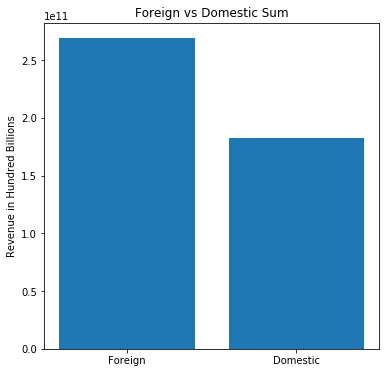

In [12]:
plt.figure(figsize=(6,6))
plt.bar(['Foreign', 'Domestic'], [foreign_sum,domestic_sum])
plt.ylabel('Revenue in Hundred Billions')
plt.title('Foreign vs Domestic Sum')
plt.show()

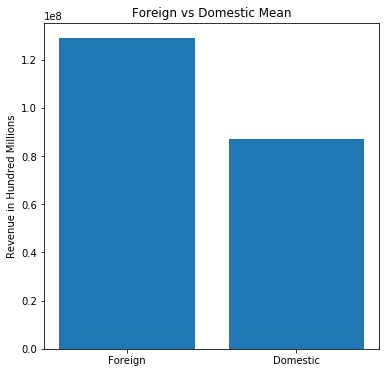

In [13]:
plt.figure(figsize=(6,6))
plt.bar(['Foreign', 'Domestic'], [foreign_mean,domestic_mean])
plt.ylabel('Revenue in Hundred Millions')
plt.title('Foreign vs Domestic Mean')
plt.show()

**While the domestic sum and mean had dips, the foreign movie market has had a high and steady positive linear correlation over time**

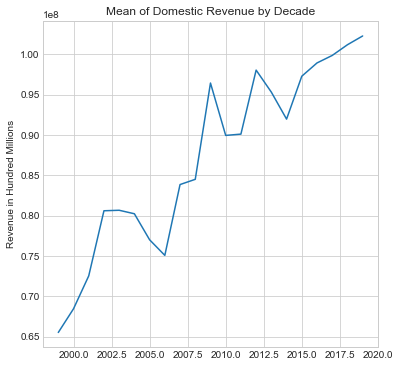

In [14]:
plt.figure(figsize=(6,6))
plt.style.use('seaborn-whitegrid')
plt.plot(decades,domestic_mean_decades[:])
plt.title('Mean of Domestic Revenue by Decade')
plt.ylabel('Revenue in Hundred Millions')
plt.show()

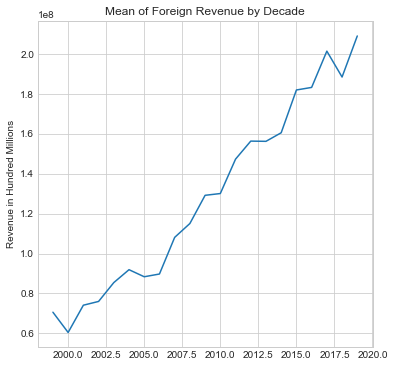

In [15]:
plt.figure(figsize=(6,6))
plt.style.use('seaborn-whitegrid')
plt.plot(decades,foreign_mean_decades[:])
plt.ylabel('Revenue in Hundred Millions')
plt.title('Mean of Foreign Revenue by Decade')
plt.show()

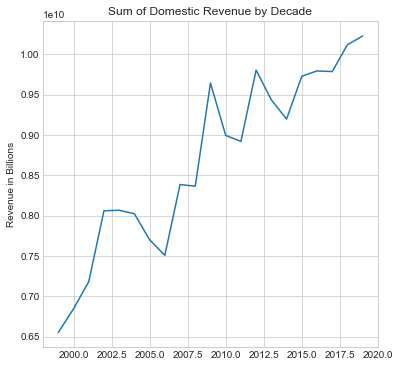

In [16]:
plt.figure(figsize=(6,6))
plt.style.use('seaborn-whitegrid')
plt.plot(decades,domestic_sum_decades[:])
plt.ylabel('Revenue in Billions')
plt.title('Sum of Domestic Revenue by Decade')
plt.show()

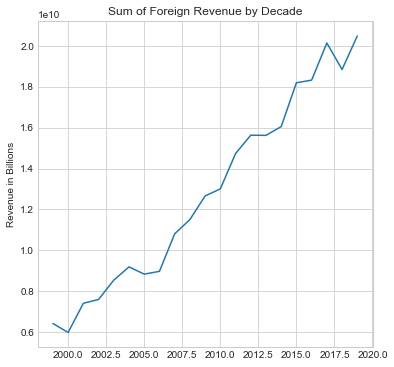

In [17]:
plt.figure(figsize=(6,6))
plt.style.use('seaborn-whitegrid')
plt.plot(decades,foreign_sum_decades[:])
plt.ylabel('Revenue in Billions')
plt.title('Sum of Foreign Revenue by Decade')
plt.show()